# Music representation in time

In [70]:
from scipy.io import wavfile
from scipy.signal import blackmanharris, gaussian
import matplotlib.pyplot as plt
import numpy as np

song = "../DSD100/Mixtures/Dev/051 - AM Contra - Heart Peripheral/mixture.wav"
sample_rate, mix_raw = wavfile.read(song)
t = np.arange(len(mix_raw), dtype=float)/sample_rate
n_channels = mix_raw.shape[1]

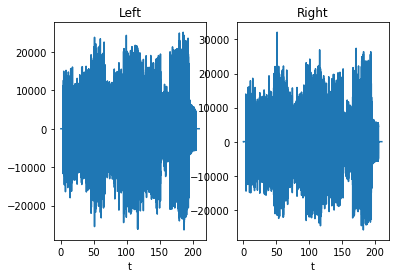

In [2]:
plt.subplot("121")
plt.plot(t, mix_raw[:,0])
plt.xlabel("t")
plt.title("Left")

plt.subplot("122")
plt.plot(t, mix_raw[:,1])
plt.xlabel("t")
plt.title("Right")
plt.show()

# Spectrogram

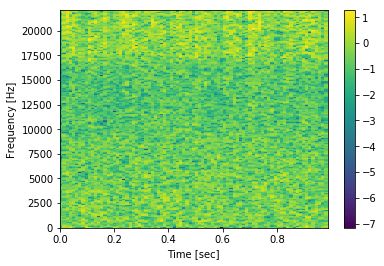

In [40]:
from phase_transform import stft_norm, PhaseTransform
nfft = 512
tt = PhaseTransform(frameSize=nfft, hopSize=nfft//4, 
                    sampleRate=sample_rate, window=blackmanharris)
# X = stft_norm(mix_raw[:,0], window=blackmanharris(4096), nfft=nfft, hopsize=1024)
mags, features = tt.compute_transform(mix_raw, phase=True)
f = np.arange(mags.shape[2])*sample_rate/nfft
t = np.arange(mags.shape[1], dtype=float)/sample_rate*nfft
logmag = np.log(1e-8 + np.abs(mags[0]))

n = int(1*sample_rate/nfft)
plt.pcolormesh(t[:n,], f[:,], logmag[:n,:].T)
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Reconstruct

In [21]:
from convsep.util import writeAudioScipy, readAudioScipy
from convsep.transform import stft_norm, istft_norm, transformFFT

raw, fs, bitrate = readAudioScipy(song)
X = stft_norm(raw[:,0])
rec = istft_norm(np.abs(X)) # phase cancellation 
rec = istft_norm(X) 
writeAudioScipy("reconst.wav", rec, 44100)

In [63]:
tt1 = transformFFT(frameSize=2048, hopSize=512, sampleRate=44100)
raw, fs, bitrate = readAudioScipy(song)
mag,ph = tt1.compute_file(raw[:,0], phase=True)
audio0 = tt1.compute_inverse(mag,ph)
mag,ph = tt1.compute_file(raw[:,1], phase=True)
audio1 = tt1.compute_inverse(mag,ph)
audio = np.stack([audio0, audio1], axis=1)
writeAudioScipy("reconst.wav", audio, 44100)

In [77]:
tt1 = PhaseTransform(frameSize=4096, hopSize=1024, window=gaussian, std=100., sampleRate=44100)
raw, fs, bitrate = readAudioScipy(song)
mag,ft = tt1.compute_file(raw[:,0], phase=True)
ph=ft[...,0]
audio0 = tt1.compute_inverse(mag,ph)
mag,ft = tt1.compute_file(raw[:,1], phase=True)
ph=ft[...,0]
audio1 = tt1.compute_inverse(mag,ph)
audio = np.stack([audio0, audio1], axis=1)
writeAudioScipy("reconst.wav", audio, 44100)

In [48]:
from scipy.io import wavfile
from scipy.signal import stft, istft

fs, raw = wavfile.read(song)
f, t, Z = stft(raw[:,0], fs=44100)
t, rec = istft(Z, fs=44100)
wavfile.write("reconst.wav", 44100, rec.astype("int16"))

# Should we use mixture phase?

In [8]:
from convsep.util import writeAudioScipy, readAudioScipy
from convsep.transform import stft_norm, istft_norm, transformFFT
sources = ["drums", "bass", "other", "vocals"]
song = "../DSD100/Mixtures/Dev/051 - AM Contra - Heart Peripheral/mixture.wav"
insts = [readAudioScipy(f"../DSD100/Sources/Dev/051 - AM Contra - Heart Peripheral/{s}.wav")[0] for s in sources]
mix, fs, bitrate = readAudioScipy(song)

tt1 = transformFFT(frameSize=2048, hopSize=512, sampleRate=44100)
mag_mix, ph_mix = tt1.compute_file(mix[:,0], phase=True)
audios = [tt1.compute_inverse(tt1.compute_file(inst[:,0], phase=True)[0], ph_mix)
          for inst in insts]
for audio, source in zip(audios, sources):
    writeAudioScipy(f"reconst-{source}.wav", audio, 44100)

# Distribution of $\nabla_t \phi$ and $\nabla_f \phi$

In [75]:
from phase_transform import PhaseTransform
from convsep.util import writeAudioScipy, readAudioScipy
from scipy.signal import blackmanharris, gaussian
import matplotlib.pyplot as plt
import numpy as np


song = "../DSD100/Mixtures/Dev/051 - AM Contra - Heart Peripheral/mixture.wav"
mix, fs, bitrate = readAudioScipy(song)
tt1 = PhaseTransform(frameSize=4096, hopSize=1024, window=gaussian, std=100., sampleRate=44100)
mag,ft = tt1.compute_file(mix[:,0], phase=True)
ph, df_ph, dt_ph = ft[..., 0], ft[..., 1], ft[..., 2]

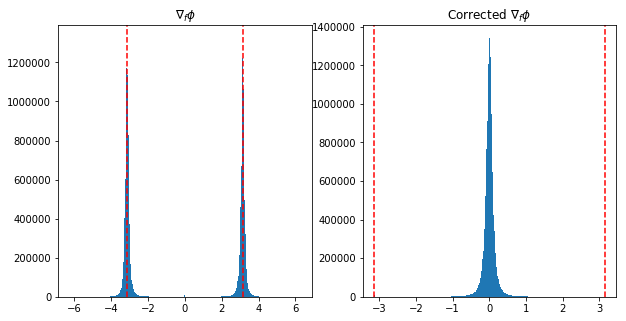

In [76]:
plt.figure(figsize=(10,5))

plt.subplot(121)
bins = plt.hist(df_ph.ravel(), bins=400)
plt.axvline(x=-np.pi, linestyle="--", color="r")
plt.axvline(x=np.pi, linestyle="--", color="r")
plt.title(r"$\nabla_f \phi$")

plt.subplot(122)
df_ph_cor = df_ph
df_ph_cor[df_ph < 0] += 2*np.pi 
df_ph_cor = df_ph - np.pi
bins = plt.hist(df_ph_cor.ravel(), bins=400)
plt.axvline(x=-np.pi, linestyle="--", color="r")
plt.axvline(x=np.pi, linestyle="--", color="r")
plt.title(r"Corrected $\nabla_f \phi$")
 
plt.show()

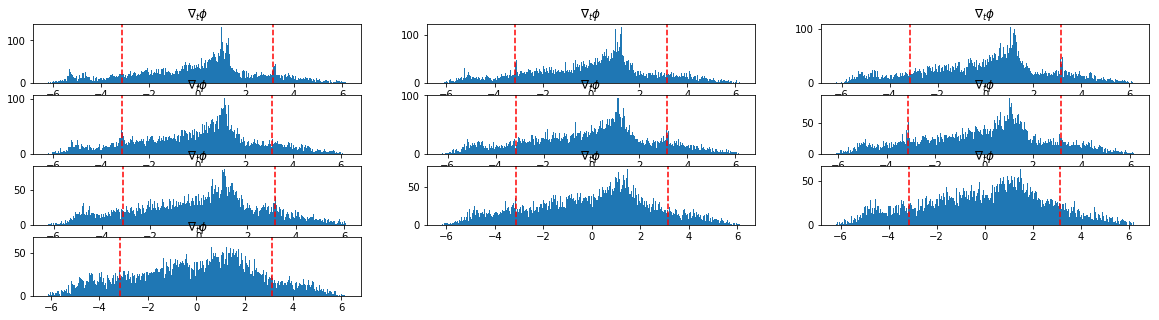

In [81]:
n = 10
plt.figure(figsize=(20,5))
for i in range(n):
    plt.subplot(4,n//3,i+1)
    bins = plt.hist(dt_ph[:,10+i].ravel(), bins=400)
    plt.axvline(x=-np.pi, linestyle="--", color="r")
    plt.axvline(x=np.pi, linestyle="--", color="r")
    plt.title(r"$\nabla_t \phi$")
plt.show()

In [ ]:
# cas d'un signal stationnaire
import numpy as np
from convsep.transform import stft_norm
from convsep.util import readAudioScipy
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft, istft

song = "../DSD100/Mixtures/Dev/051 - AM Contra - Heart Peripheral/mixture.wav"
mix, fs, bitrate = readAudioScipy(song)
# fs, raw = wavfile.read(song)
X = stft_norm(mix[:,0])
mag = np.abs(X)
ph = np.angle(X)
dt_ph = np.pad(np.diff(ph, axis=0), ((1,0),(0,0)), 'constant', constant_values=0)

n = 4
plt.figure(figsize=(20,5))
for i in range(n):
    plt.subplot(2,n//2,i+1)
    bins = plt.hist(dt_ph[:,10+i].ravel(), bins=400)
    plt.axvline(x=-np.pi, linestyle="--", color="r")
    plt.axvline(x=np.pi, linestyle="--", color="r")
    plt.title(r"$\nabla_t \phi$")
plt.show()

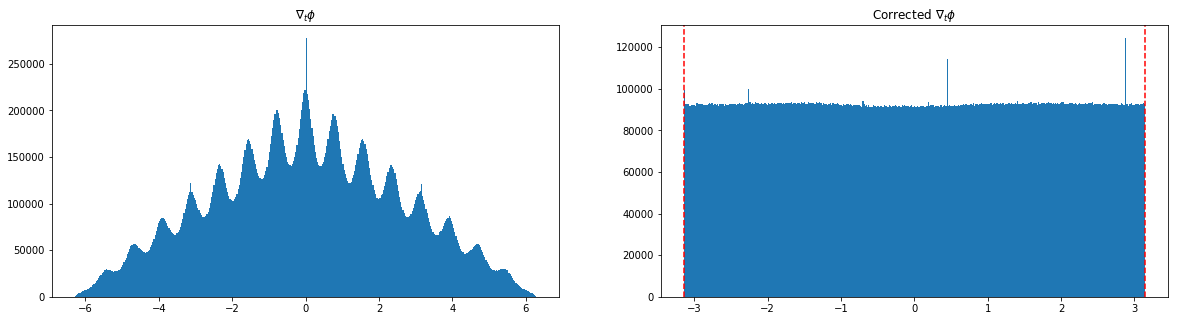

In [46]:
# correction
K = dt_ph.shape[1]
lin_term = np.broadcast_to(np.arange(K)*2*np.pi*512/4096, dt_ph.shape) % 2*np.pi
dt_ph_cor = dt_ph + lin_term
dt_ph_cor = (dt_ph_cor + np.pi) % 2*np.pi - np.pi
n = 4
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(dt_ph.ravel(), bins=400)
# plt.hist(lin_term.ravel(), bins=400)
plt.title(r"$\nabla_t \phi$")
plt.subplot(122)
plt.hist(dt_ph_cor.ravel(), bins=400)
plt.axvline(x=-np.pi, linestyle="--", color="r")
plt.axvline(x=np.pi, linestyle="--", color="r")
plt.title(r"Corrected $\nabla_t \phi$")
plt.show()